# Load Packages

In [ ]:
import os
import sys
sys.path.append('..')
from data_generation.model import StableDiffusionXLImg2ImgPipeline
import torch
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from typing import List, Dict, Tuple
import numpy as np
import random
from string import Template

device = "cuda" if torch.cuda.is_available() else "cpu"

# Used stable diffusion model
sd_model = "stabilityai/stable-diffusion-xl-refiner-1.0"
# Used clip model
clip_model = "openai/clip-vit-base-patch32"

with open(f'../assets/metadata/wilds_common_names.pkl', 'rb') as f:
    dict_name = pickle.load(f)

In [28]:
def show_generated_img(list_generated: List, list_img_guid: List, list_seed: List):
    fig, axs = plt.subplots(nrows=len(list_seed), ncols=len(list_img_guid), figsize=(8, 3))
    
    # Dictionary to map x and y values to subplot indices
    x_mapping = {img_guid: i for i, img_guid in enumerate(sorted(list_img_guid, reverse=True))}
    y_mapping = {seed: i for i, seed in enumerate(list_seed)}
    
    for item in list_generated:
        if len(item) == 3:
            img, y_val, x_val = item
        else:
            img, y_val, x_val, text_cos, img_cos = item
            
        ax = axs[y_mapping[y_val], x_mapping[x_val]]
        ax.imshow(img)
        ax.axis('off') 
        ax.set_title(f'Img Guid: {int(x_val*100)}')
    
    plt.tight_layout()
    plt.show()
    return 

In [4]:
img_path = '../assets/metadata/Samples/Image1.jpg'
img_name = img_path.split('/')[-1]
# class name for sample images, used to search for common name in dict_name
sp_name = 'acinonyx_jubatus'

# saved folder
output_folder = 'GeneratedImg'

# 0: Generate images from random noise
img_guidances = [0, 0.1, 0.3, 0.5, 0.7, 0.9, ]
text_guidance = 10
random_seed = [10, 20, 30, 40]

# prompt for generation and filtering
template_string = Template("a photo of $classname in the wild")

## Generate Synthetic Images

In [5]:
def init_sd_model(model_id_or_path: str, device: str):
    # loading stable diffusion pipeline
    if device == 'cpu':
        pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(model_id_or_path, use_safetensors=True).to(device)
    else:
        pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16, variant="fp16", use_safetensors=True).to(device)
    return pipe
    
def set_seed(cur_seed: int = 42) -> None:
    np.random.seed(cur_seed)
    random.seed(cur_seed)
    torch.manual_seed(cur_seed)
    torch.cuda.manual_seed(cur_seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(cur_seed)
    # print(f"Random seed set as {seed}")

def create_folder_generate(img, prompt: str, img_guid: float, text_guid: float, out_folder: str, out_name: str, seed: int=42):

    out_folder_n = os.path.join(out_folder, f'ImgGuid{int(img_guid*100)}_seed{seed}')
    os.makedirs(out_folder_n, exist_ok=True)

    gene_img = generate_img(img=img, prompt=prompt, img_guid=img_guid, text_guid=text_guid, out_folder=out_folder_n, out_name=out_name, seed=seed)
    return gene_img

def generate_img(img, prompt: str, img_guid: float, text_guid: float, out_folder: str, out_name: str, seed: int=42):
    """Generate denoised image based on given prompt

    :param _type_ img: _description_
    :param str prompt: _description_
    :param float img_guid: _description_
    :param float text_guid: _description_
    :param str out_folder: _description_
    :param str out_name: _description_
    :param str seed: _description_
    """
    set_seed(cur_seed=seed)
    results = pipe(prompt=prompt, image=img, strength=1-img_guid, guidance_scale=text_guid)
    images = results.images
    output_f = f"{out_folder}/{out_name}.jpg"
    images[0].save(output_f)
    return images[0]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Generated images: 


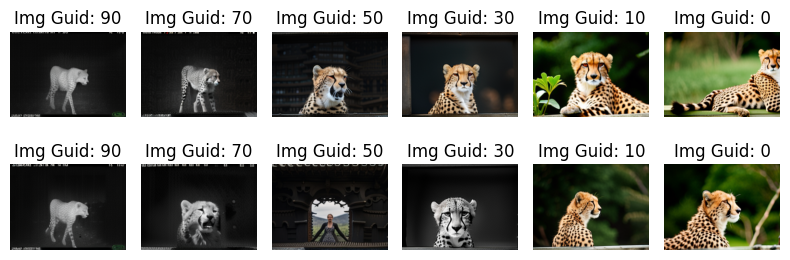

In [29]:
init_image = Image.open(img_path).convert("RGB")
init_image = init_image.resize((400, 300))

common_name = dict_name[sp_name]
data = { 'classname': common_name, }
cur_prompt = template_string.substitute(data)
pipe = init_sd_model(sd_model, device)

List_generated = []
for ranseed in random_seed:
    for img_guid in img_guidances:
        combined_seed = (hash(sp_name) + hash(img_path)) ^ ranseed
        combined_seed %= 2**32

        gene_img = create_folder_generate(img=init_image, prompt=cur_prompt, img_guid=img_guid, text_guid=text_guidance, out_folder=output_folder, out_name=img_name.replace('.jpg', ''), seed=combined_seed)
        List_generated.append([gene_img, ranseed, img_guid])

print(f"Generated images: ")
show_generated_img(List_generated, img_guidances, random_seed)

## Filter generated images

In [30]:
def init_clip_model(model_id_or_path: str, device: str):
    # Save the model to device
    model = CLIPModel.from_pretrained(model_id_or_path).to(device)
    # Get the processor
    processor = CLIPProcessor.from_pretrained(model_id_or_path)
    # Get the tokenizer
    tokenizer = CLIPTokenizer.from_pretrained(model_id_or_path)
    return model, processor, tokenizer

def get_single_text_embedding(tokenizer, model, text): 
    inputs = tokenizer(text, return_tensors = "pt").to(device)
    text_embeddings = model.get_text_features(**inputs)
    # convert the embeddings to numpy array
    embedding_as_np = text_embeddings.cpu().detach().numpy()
    return embedding_as_np

def get_single_image_embedding(processor, model, my_image, do_rescale=True):
    image = processor(
        text = None,
        images = my_image,
        return_tensors="pt",
        do_rescale=do_rescale
        )["pixel_values"].to(device)
    embedding = model.get_image_features(image)
    # convert the embeddings to numpy array
    embedding_as_np = embedding.cpu().detach().numpy()
    return embedding_as_np

Generated images after filtering: 


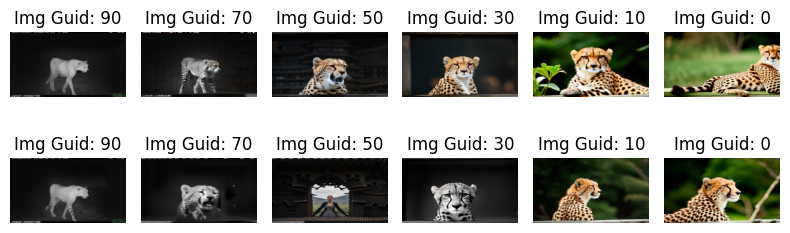

In [31]:
init_image = init_image.resize((480,270))
model, processor, tokenizer = init_clip_model(clip_model, device)

data = { 'classname': common_name, }
cur_prompt = template_string.substitute(data)

List_clipscore = []
for gene_img, seed, img_guid in List_generated:
    gene_img = gene_img.resize((480,270))
    init_image = init_image.resize((480,270))

    img_embedding = get_single_image_embedding(processor, model, init_image)
    real_img_embedding = get_single_image_embedding(processor, model, gene_img)
    text_embedding = get_single_text_embedding(tokenizer, model, cur_prompt)

    text_sim = cosine_similarity(img_embedding, text_embedding)[0][0]
    img_sim = cosine_similarity(img_embedding, real_img_embedding)[0][0]
    List_clipscore.append([gene_img, seed, img_guid, text_sim, img_sim])

print(f"Generated images after filtering: ")
List_filtered = [item for item in List_clipscore if item[-2] >= 0.25]
show_generated_img(List_filtered, img_guidances, random_seed)